# Flood Prediction — Feature-Engineered Stacking (v6)
*Generated 2025-08-11 14:00*

This notebook builds **per-station stacking classifiers** (XGB + RF + GB + LR + MLP → Logistic Regression) on engineered hydrological features, applies your **manual thresholds** per station, and then performs a small **auto‑nudge** around each threshold to further reduce false positives **without increasing false negatives**.

### Feature engineering (what we add and why)
- **Rolling rainfall sums (1/3/6/12/24h)** — near-term accumulation driving runoff.
- **EWMA rainfall (halflife=12h)** — exponential antecedent wetness.
- **Discharge lags (1–12h)** — river inertia / memory.
- **Discharge rates (Δ1h, Δ3h)** — rapid rises signal event onset.
- **Rolling discharge stats (max/min/std over 3/6/12h)** — current regime/volatility.
- **Dry-spell counter (hours since last rain > 0)** — antecedent dryness.
- **Interactions** — e.g., `rain_sum_3h × dis_lag_1h`, `rain_sum_6h × dis_lag_3h`.
- **Seasonality (sin/cos of hour-of-day, day-of-year)** — diurnal/seasonal patterns.

### Labels & split
- **Flood label**: discharge above the station’s **82nd percentile**, shifted by **+2 hours** (predicting 2h ahead).
- **Split**: **70/30 stratified random** per station.

### Thresholding
- Uses your manual thresholds: `D08A071: 0.50`, `D08A084: 0.50`, `D08A115: 0.95`.
- Then **auto‑nudges** ±0.05 to decrease FP while keeping FN ≤ base FN.


In [3]:

# %% Imports
import warnings, numpy as np, pandas as pd
warnings.filterwarnings("ignore")

from pathlib import Path
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_recall_curve, average_precision_score,
    confusion_matrix, precision_score, recall_score, accuracy_score
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=(8,4)
plt.rcParams["axes.grid"]=True


In [4]:

# %% Config
SEED = 42

# Update this path to your data root
DATA_RAW = Path('/Users/tree/Projects/hydro-flood-poc/data/raw')

STATIONS = ['D08A071','D08A084','D08A115']

# Labeling & prediction
PERCENTILE = 0.82     # per-station flood definition
LEAD_HRS   = 2        # predict flood at t+2h

# Windows
ROLL_RAIN  = [1,3,6,12,24]
LAG_Q      = list(range(1,13))
ROLL_Q_MAX = [3,6,12]
ROLL_Q_MIN = [3,6,12]
ROLL_Q_STD = [3,6,12]
EWMA_RAIN_HALFLIFE = 12

# Your manual thresholds
MY_THR = {'D08A071': 0.50, 'D08A084': 0.50, 'D08A115': 0.95}
PERSISTENCE_HRS = 3
COOLDOWN_HRS    = 6

# Optional models
USE_LGBM = True   # auto-disables if LightGBM not installed
USE_LSTM = False  # enable only if SciKeras + TensorFlow available


In [5]:

# %% Loading helpers
def find_csv_for_station(root: Path, code: str) -> Path:
    folder = root / f'station_{code}'
    cands = sorted(folder.glob('*.csv'))
    if not cands:
        raise FileNotFoundError(f'No CSV found in {folder}')
    return cands[0]

def load_station(code: str) -> pd.DataFrame:
    csv = find_csv_for_station(DATA_RAW, code)
    df  = pd.read_csv(csv)
    df['datetime'] = pd.to_datetime(df['saatlik'])
    df = (df.rename(columns={'yagis_toplam':'rain_mm','qdeger':'discharge_cms'})
            .set_index('datetime').sort_index())
    # regular hourly grid
    df = df.resample('h').agg({'rain_mm':'sum','discharge_cms':'mean'})
    df = df[~df.index.duplicated(keep='first')]
    return df

def add_seasonal_features(idx: pd.DatetimeIndex) -> pd.DataFrame:
    hour = idx.hour.values
    doy  = idx.dayofyear.values
    feat = pd.DataFrame(index=idx)
    feat['hour_sin'] = np.sin(2*np.pi*hour/24)
    feat['hour_cos'] = np.cos(2*np.pi*hour/24)
    feat['doy_sin']  = np.sin(2*np.pi*doy/366)
    feat['doy_cos']  = np.cos(2*np.pi*doy/366)
    return feat

def build_features(base: pd.DataFrame):
    df = base.copy()

    # Rolling rainfall
    for w in ROLL_RAIN:
        df[f'rain_sum_{w}h'] = df['rain_mm'].rolling(w, min_periods=1).sum()

    # EWMA rain (antecedent wetness)
    df['rain_ewm'] = df['rain_mm'].ewm(halflife=EWMA_RAIN_HALFLIFE, adjust=False).mean()

    # Discharge lags & dynamics
    for l in LAG_Q:
        df[f'dis_lag_{l}h'] = df['discharge_cms'].shift(l)
    df['dis_rate_1h'] = df['discharge_cms'].diff(1)
    df['dis_rate_3h'] = df['discharge_cms'].diff(3)

    # Rolling stats of discharge
    for w in ROLL_Q_MAX: df[f'dis_max_{w}h'] = df['discharge_cms'].rolling(w, min_periods=1).max()
    for w in ROLL_Q_MIN: df[f'dis_min_{w}h'] = df['discharge_cms'].rolling(w, min_periods=1).min()
    for w in ROLL_Q_STD: df[f'dis_std_{w}h'] = df['discharge_cms'].rolling(w, min_periods=3).std()

    # Dry-spell (hours since last rain)
    rain_bool = (df['rain_mm'] > 0).astype(int)
    gaps, count = [], 0
    for val in rain_bool:
        count = 0 if val == 1 else count + 1
        gaps.append(count)
    df['hrs_since_rain'] = gaps

    # Interactions
    df['rain3xlag1'] = df.get('rain_sum_3h', 0) * df.get('dis_lag_1h', 0)
    df['rain6xlag3'] = df.get('rain_sum_6h', 0) * df.get('dis_lag_3h', 0)

    # Seasonality
    df = df.join(add_seasonal_features(df.index))

    # Label (percentile on discharge, then shift to t+LEAD_HRS)
    thr = df['discharge_cms'].quantile(PERCENTILE)
    y = (df['discharge_cms'] > thr).astype(int).shift(-LEAD_HRS)

    # Drop NaNs from rolling/lagging/shift
    df['flood'] = y
    df = df.dropna()

    feat_cols = [c for c in df.columns if c != 'flood']
    return df[feat_cols], df['flood']


In [6]:

# %% Models & threshold utilities
def make_base_models(n_pos: int, n_neg: int):
    spw = (n_neg / max(1, n_pos)) if n_pos>0 else 1.0
    models = [
        ('xgb', XGBClassifier(
            n_estimators=500, max_depth=6, learning_rate=0.05,
            subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
            random_state=SEED, tree_method='hist', eval_metric='logloss',
            scale_pos_weight=spw
        )),
        ('rf',  RandomForestClassifier(
            n_estimators=400, max_depth=None, min_samples_leaf=2,
            class_weight='balanced', random_state=SEED, n_jobs=-1
        )),
        ('gb',  GradientBoostingClassifier(
            learning_rate=0.05, n_estimators=500, max_depth=3, random_state=SEED
        )),
        ('lr',  LogisticRegression(
            max_iter=2000, class_weight='balanced', solver='lbfgs', random_state=SEED
        )),
        ('mlp', MLPClassifier(
            hidden_layer_sizes=(64,32), activation='relu', alpha=1e-3,
            max_iter=600, random_state=SEED
        )),
    ]
    # Optional LightGBM
    try:
        import lightgbm as lgb
        if USE_LGBM:
            models.append(('lgbm', lgb.LGBMClassifier(
                n_estimators=600, learning_rate=0.05, max_depth=-1,
                subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
                class_weight='balanced', random_state=SEED, n_jobs=-1
            )))
    except Exception:
        pass
    return models

def make_stacker(base_models):
    meta = LogisticRegression(max_iter=2000, class_weight='balanced', solver='lbfgs', random_state=SEED)
    stack = StackingClassifier(
        estimators=base_models,
        final_estimator=meta,
        stack_method='predict_proba',
        passthrough=True,
        cv=5, n_jobs=-1
    )
    return stack

def evaluate_at_threshold(y_true, y_prob, thr):
    y_hat = (y_prob >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_hat, labels=[0,1]).ravel()
    acc = (tp+tn)/(tp+tn+fp+fn)
    prec = precision_score(y_true, y_hat, zero_division=0)
    rec  = recall_score(y_true, y_hat)
    ap   = average_precision_score(y_true, y_prob)
    return dict(threshold=float(thr), acc=acc, precision=prec, recall=rec, ap=ap,
                tn=int(tn), fp=int(fp), fn=int(fn), tp=int(tp))


In [7]:

# %% Sanity helpers (printing samples)
def _dist(y):
    vc = y.value_counts()
    tot = int(vc.sum()); pos = int(vc.get(1,0)); neg = int(vc.get(0,0))
    return f"{pos}/{tot}  ({pos/tot:.2%} pos)"

def first_consecutive_index(idx, n=5):
    idx = pd.Index(idx).sort_values()
    for i in range(len(idx) - n + 1):
        base_t = idx[i]
        if all(idx[i+k] == base_t + pd.Timedelta(hours=k) for k in range(n)):
            return idx[i:i+n]
    return idx[:n]



=== Station D08A071 ===

[D08A071] raw hourly sample (rain_mm, discharge_cms)


,rain_mm,discharge_cms
datetime,,
2014-01-01 00:00:00,0.0,0.728
2014-01-01 01:00:00,0.0,0.728
2014-01-01 02:00:00,0.0,0.728
2014-01-01 03:00:00,0.0,0.728
2014-01-01 04:00:00,0.0,0.728


[D08A071] engineered features + label (first 5 rows)


,rain_mm,discharge_cms,rain_sum_1h,rain_sum_3h,rain_sum_6h,rain_sum_12h,rain_sum_24h,rain_ewm,dis_lag_1h,dis_lag_2h,...,dis_std_6h,dis_std_12h,hrs_since_rain,rain3xlag1,rain6xlag3,hour_sin,hour_cos,doy_sin,doy_cos,flood
datetime,,,,,,,,,,,,,,,,,,,,,
2014-01-01 12:00:00,0.0,0.683,0.0,0.0,0.0,0.0,0.0,0.0,0.683,0.683,...,0.018371,0.023172,13,0.0,0.0,1.224647e-16,-1.000000,0.017166,0.999853,0.0
2014-01-01 13:00:00,0.0,0.683,0.0,0.0,0.0,0.0,0.0,0.0,0.683,0.683,...,0.000000,0.023500,14,0.0,0.0,-2.588190e-01,-0.965926,0.017166,0.999853,0.0
2014-01-01 14:00:00,0.0,0.683,0.0,0.0,0.0,0.0,0.0,0.0,0.683,0.683,...,0.000000,0.023172,15,0.0,0.0,-5.000000e-01,-0.866025,0.017166,0.999853,0.0
2014-01-01 15:00:00,0.0,0.683,0.0,0.0,0.0,0.0,0.0,0.0,0.683,0.683,...,0.000000,0.022156,16,0.0,0.0,-7.071068e-01,-0.707107,0.017166,0.999853,0.0
2014-01-01 16:00:00,0.0,0.683,0.0,0.0,0.0,0.0,0.0,0.0,0.683,0.683,...,0.000000,0.020352,17,0.0,0.0,-8.660254e-01,-0.500000,0.017166,0.999853,0.0


[D08A071] rows=25,549, features=38
  overall flood rate : 4646/25549  (18.18% pos)
  time span: 2014-01-01 12:00:00 → 2024-12-31 21:00:00
[D08A071] train/test split → X_train:(17884, 38), X_test:(7665, 38)
  train flood rate: 3252/17884  (18.18% pos)
  test  flood rate: 1394/7665  (18.19% pos)
[D08A071] first 5 consecutive TRAIN rows:


,rain_mm,discharge_cms,rain_sum_1h,rain_sum_3h,rain_sum_6h,rain_sum_12h,rain_sum_24h,rain_ewm,dis_lag_1h,dis_lag_2h,...,dis_std_6h,dis_std_12h,hrs_since_rain,rain3xlag1,rain6xlag3,hour_sin,hour_cos,doy_sin,doy_cos,label
datetime,,,,,,,,,,,,,,,,,,,,,
2014-01-01 14:00:00,0.0,0.683,0.0,0.0,0.0,0.0,0.0,0.0,0.683,0.683,...,0.000000,0.023172,15,0.0,0.0,-0.500000,-8.660254e-01,0.017166,0.999853,0.0
2014-01-01 15:00:00,0.0,0.683,0.0,0.0,0.0,0.0,0.0,0.0,0.683,0.683,...,0.000000,0.022156,16,0.0,0.0,-0.707107,-7.071068e-01,0.017166,0.999853,0.0
2014-01-01 16:00:00,0.0,0.683,0.0,0.0,0.0,0.0,0.0,0.0,0.683,0.683,...,0.000000,0.020352,17,0.0,0.0,-0.866025,-5.000000e-01,0.017166,0.999853,0.0
2014-01-01 17:00:00,0.0,0.683,0.0,0.0,0.0,0.0,0.0,0.0,0.683,0.683,...,0.000000,0.017516,18,0.0,0.0,-0.965926,-2.588190e-01,0.017166,0.999853,0.0
2014-01-01 18:00:00,0.0,0.638,0.0,0.0,0.0,0.0,0.0,0.0,0.683,0.683,...,0.018371,0.019188,19,0.0,0.0,-1.000000,-1.836970e-16,0.017166,0.999853,0.0


[D08A071] first 5 consecutive TEST rows:


,rain_mm,discharge_cms,rain_sum_1h,rain_sum_3h,rain_sum_6h,rain_sum_12h,rain_sum_24h,rain_ewm,dis_lag_1h,dis_lag_2h,...,dis_std_6h,dis_std_12h,hrs_since_rain,rain3xlag1,rain6xlag3,hour_sin,hour_cos,doy_sin,doy_cos,label
datetime,,,,,,,,,,,,,,,,,,,,,
2014-01-08 11:00:00,0.0,0.638,0.0,0.0,0.0,0.0,0.0,0.003941,0.638,0.638,...,0.0,0.0,48,0.0,0.0,2.588190e-01,-0.965926,0.136906,0.990584,0.0
2014-01-08 12:00:00,0.0,0.638,0.0,0.0,0.0,0.0,0.0,0.003720,0.638,0.638,...,0.0,0.0,49,0.0,0.0,1.224647e-16,-1.000000,0.136906,0.990584,0.0
2014-01-08 13:00:00,0.0,0.638,0.0,0.0,0.0,0.0,0.0,0.003511,0.638,0.638,...,0.0,0.0,50,0.0,0.0,-2.588190e-01,-0.965926,0.136906,0.990584,0.0
2014-01-08 14:00:00,0.0,0.638,0.0,0.0,0.0,0.0,0.0,0.003314,0.638,0.638,...,0.0,0.0,51,0.0,0.0,-5.000000e-01,-0.866025,0.136906,0.990584,0.0
2014-01-08 15:00:00,0.0,0.638,0.0,0.0,0.0,0.0,0.0,0.003128,0.638,0.638,...,0.0,0.0,52,0.0,0.0,-7.071068e-01,-0.707107,0.136906,0.990584,0.0


[D08A071] proba summary → min:0.000  25%:0.002  50%:0.004  75%:0.006  max:1.000
[D08A071] chosen thr=0.500 (manual)


,y_true,prob,y_pred
datetime,,,
2014-01-01 13:00:00,0.0,0.003786,0
2014-01-01 21:00:00,0.0,0.002985,0
2014-01-01 23:00:00,0.0,0.003139,0
2014-01-02 01:00:00,0.0,0.003443,0
2014-01-02 04:00:00,0.0,0.003981,0


AP=0.993  Acc=0.996  Prec=0.984  Rec=0.994
CM:
[[ 6248    23]
 [    8  1386]]


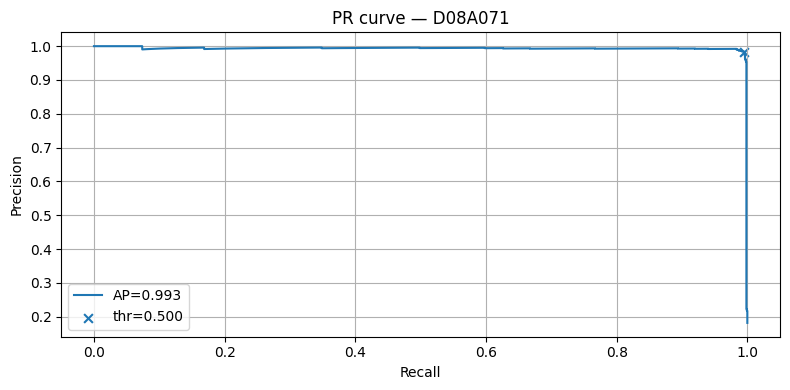


=== Station D08A084 ===

[D08A084] raw hourly sample (rain_mm, discharge_cms)


,rain_mm,discharge_cms
datetime,,
2016-02-25 05:00:00,0.0,0.011
2016-02-25 06:00:00,0.0,0.011
2016-02-25 07:00:00,0.0,0.011
2016-02-25 08:00:00,0.0,0.011
2016-02-25 09:00:00,0.0,0.011


[D08A084] engineered features + label (first 5 rows)


,rain_mm,discharge_cms,rain_sum_1h,rain_sum_3h,rain_sum_6h,rain_sum_12h,rain_sum_24h,rain_ewm,dis_lag_1h,dis_lag_2h,...,dis_std_6h,dis_std_12h,hrs_since_rain,rain3xlag1,rain6xlag3,hour_sin,hour_cos,doy_sin,doy_cos,flood
datetime,,,,,,,,,,,,,,,,,,,,,
2016-02-25 17:00:00,0.0,0.011,0.0,0.0,0.0,0.0,0.0,0.0,0.011,0.011,...,0.0,0.0,13,0.0,0.0,-0.965926,-2.588190e-01,0.819972,0.572404,0.0
2016-02-25 18:00:00,0.0,0.011,0.0,0.0,0.0,0.0,0.0,0.0,0.011,0.011,...,0.0,0.0,14,0.0,0.0,-1.000000,-1.836970e-16,0.819972,0.572404,0.0
2016-02-25 19:00:00,0.0,0.011,0.0,0.0,0.0,0.0,0.0,0.0,0.011,0.011,...,0.0,0.0,15,0.0,0.0,-0.965926,2.588190e-01,0.819972,0.572404,0.0
2016-02-25 20:00:00,0.0,0.011,0.0,0.0,0.0,0.0,0.0,0.0,0.011,0.011,...,0.0,0.0,16,0.0,0.0,-0.866025,5.000000e-01,0.819972,0.572404,0.0
2016-02-25 21:00:00,0.0,0.011,0.0,0.0,0.0,0.0,0.0,0.0,0.011,0.011,...,0.0,0.0,17,0.0,0.0,-0.707107,7.071068e-01,0.819972,0.572404,0.0


[D08A084] rows=31,965, features=38
  overall flood rate : 2866/31965  (8.97% pos)
  time span: 2016-02-25 17:00:00 → 2024-12-31 21:00:00
[D08A084] train/test split → X_train:(22375, 38), X_test:(9590, 38)
  train flood rate: 2006/22375  (8.97% pos)
  test  flood rate: 860/9590  (8.97% pos)
[D08A084] first 5 consecutive TRAIN rows:


,rain_mm,discharge_cms,rain_sum_1h,rain_sum_3h,rain_sum_6h,rain_sum_12h,rain_sum_24h,rain_ewm,dis_lag_1h,dis_lag_2h,...,dis_std_6h,dis_std_12h,hrs_since_rain,rain3xlag1,rain6xlag3,hour_sin,hour_cos,doy_sin,doy_cos,label
datetime,,,,,,,,,,,,,,,,,,,,,
2016-02-25 19:00:00,0.0,0.011,0.0,0.0,0.0,0.0,0.0,0.0,0.011,0.011,...,0.0,0.0,15,0.0,0.0,-0.965926,0.258819,0.819972,0.572404,0.0
2016-02-25 20:00:00,0.0,0.011,0.0,0.0,0.0,0.0,0.0,0.0,0.011,0.011,...,0.0,0.0,16,0.0,0.0,-0.866025,0.500000,0.819972,0.572404,0.0
2016-02-25 21:00:00,0.0,0.011,0.0,0.0,0.0,0.0,0.0,0.0,0.011,0.011,...,0.0,0.0,17,0.0,0.0,-0.707107,0.707107,0.819972,0.572404,0.0
2016-02-25 22:00:00,0.0,0.011,0.0,0.0,0.0,0.0,0.0,0.0,0.011,0.011,...,0.0,0.0,18,0.0,0.0,-0.500000,0.866025,0.819972,0.572404,0.0
2016-02-25 23:00:00,0.0,0.011,0.0,0.0,0.0,0.0,0.0,0.0,0.011,0.011,...,0.0,0.0,19,0.0,0.0,-0.258819,0.965926,0.819972,0.572404,0.0


[D08A084] first 5 consecutive TEST rows:


,rain_mm,discharge_cms,rain_sum_1h,rain_sum_3h,rain_sum_6h,rain_sum_12h,rain_sum_24h,rain_ewm,dis_lag_1h,dis_lag_2h,...,dis_std_6h,dis_std_12h,hrs_since_rain,rain3xlag1,rain6xlag3,hour_sin,hour_cos,doy_sin,doy_cos,label
datetime,,,,,,,,,,,,,,,,,,,,,
2016-03-17 16:00:00,0.0,0.011,0.0,0.0,0.0,0.0,0.0,0.024445,0.011,0.011,...,0.0,0.0,42,0.0,0.0,-0.866025,-5.000000e-01,0.969178,0.246361,0.0
2016-03-17 17:00:00,0.0,0.011,0.0,0.0,0.0,0.0,0.0,0.023073,0.011,0.011,...,0.0,0.0,43,0.0,0.0,-0.965926,-2.588190e-01,0.969178,0.246361,0.0
2016-03-17 18:00:00,0.0,0.011,0.0,0.0,0.0,0.0,0.0,0.021778,0.011,0.011,...,0.0,0.0,44,0.0,0.0,-1.000000,-1.836970e-16,0.969178,0.246361,0.0
2016-03-17 19:00:00,0.0,0.011,0.0,0.0,0.0,0.0,0.0,0.020556,0.011,0.011,...,0.0,0.0,45,0.0,0.0,-0.965926,2.588190e-01,0.969178,0.246361,0.0
2016-03-17 20:00:00,0.0,0.011,0.0,0.0,0.0,0.0,0.0,0.019402,0.011,0.011,...,0.0,0.0,46,0.0,0.0,-0.866025,5.000000e-01,0.969178,0.246361,0.0


[D08A084] proba summary → min:0.001  25%:0.003  50%:0.006  75%:0.020  max:1.000
[D08A084] chosen thr=0.500 (manual)


,y_true,prob,y_pred
datetime,,,
2016-02-25 18:00:00,0.0,0.021442,0
2016-02-26 15:00:00,0.0,0.032143,0
2016-02-26 17:00:00,0.0,0.024616,0
2016-02-26 19:00:00,0.0,0.019028,0
2016-02-26 22:00:00,0.0,0.015391,0


AP=0.974  Acc=0.991  Prec=0.917  Rec=0.987
CM:
[[ 8653    77]
 [   11   849]]


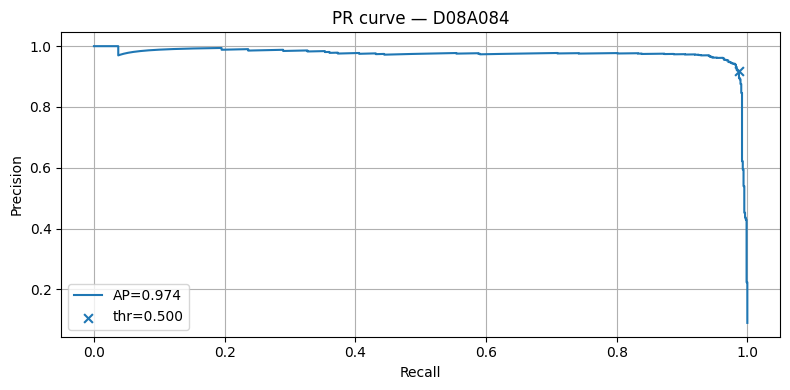


=== Station D08A115 ===

[D08A115] raw hourly sample (rain_mm, discharge_cms)


,rain_mm,discharge_cms
datetime,,
2016-02-23 10:00:00,0.0,1.122
2016-02-23 11:00:00,0.0,1.122
2016-02-23 12:00:00,0.0,1.122
2016-02-23 13:00:00,0.0,1.122
2016-02-23 14:00:00,0.0,1.122


[D08A115] engineered features + label (first 5 rows)


,rain_mm,discharge_cms,rain_sum_1h,rain_sum_3h,rain_sum_6h,rain_sum_12h,rain_sum_24h,rain_ewm,dis_lag_1h,dis_lag_2h,...,dis_std_6h,dis_std_12h,hrs_since_rain,rain3xlag1,rain6xlag3,hour_sin,hour_cos,doy_sin,doy_cos,flood
datetime,,,,,,,,,,,,,,,,,,,,,
2016-02-23 22:00:00,0.0,1.122,0.0,0.0,0.0,0.0,0.0,0.0,1.122,1.122,...,0.0,0.0,13,0.0,0.0,-0.500000,0.866025,0.799839,0.600214,0.0
2016-02-23 23:00:00,0.0,1.122,0.0,0.0,0.0,0.0,0.0,0.0,1.122,1.122,...,0.0,0.0,14,0.0,0.0,-0.258819,0.965926,0.799839,0.600214,0.0
2016-02-24 13:00:00,0.0,1.122,0.0,0.0,0.0,0.0,0.0,0.0,1.122,1.122,...,0.0,0.0,28,0.0,0.0,-0.258819,-0.965926,0.810025,0.586396,0.0
2016-02-24 14:00:00,0.0,1.122,0.0,0.0,0.0,0.0,0.0,0.0,1.122,1.122,...,0.0,0.0,29,0.0,0.0,-0.500000,-0.866025,0.810025,0.586396,0.0
2016-02-24 15:00:00,0.0,1.122,0.0,0.0,0.0,0.0,0.0,0.0,1.122,1.122,...,0.0,0.0,30,0.0,0.0,-0.707107,-0.707107,0.810025,0.586396,0.0


[D08A115] rows=21,939, features=38
  overall flood rate : 4286/21939  (19.54% pos)
  time span: 2016-02-23 22:00:00 → 2024-12-31 21:00:00
[D08A115] train/test split → X_train:(15357, 38), X_test:(6582, 38)
  train flood rate: 3000/15357  (19.54% pos)
  test  flood rate: 1286/6582  (19.54% pos)
[D08A115] first 5 consecutive TRAIN rows:


,rain_mm,discharge_cms,rain_sum_1h,rain_sum_3h,rain_sum_6h,rain_sum_12h,rain_sum_24h,rain_ewm,dis_lag_1h,dis_lag_2h,...,dis_std_6h,dis_std_12h,hrs_since_rain,rain3xlag1,rain6xlag3,hour_sin,hour_cos,doy_sin,doy_cos,label
datetime,,,,,,,,,,,,,,,,,,,,,
2016-02-26 15:00:00,0.0,1.122,0.0,0.0,0.0,0.030774,0.030774,0.001027,1.122,1.122,...,0.0,0.0,9,0.0,0.0,-0.707107,-7.071068e-01,0.829677,0.558244,0.0
2016-02-26 16:00:00,0.0,1.122,0.0,0.0,0.0,0.030774,0.030774,0.000969,1.122,1.122,...,0.0,0.0,10,0.0,0.0,-0.866025,-5.000000e-01,0.829677,0.558244,0.0
2016-02-26 17:00:00,0.0,1.122,0.0,0.0,0.0,0.030774,0.030774,0.000915,1.122,1.122,...,0.0,0.0,11,0.0,0.0,-0.965926,-2.588190e-01,0.829677,0.558244,0.0
2016-02-26 18:00:00,0.0,1.122,0.0,0.0,0.0,0.000000,0.030774,0.000864,1.122,1.122,...,0.0,0.0,12,0.0,0.0,-1.000000,-1.836970e-16,0.829677,0.558244,0.0
2016-02-26 19:00:00,0.0,1.122,0.0,0.0,0.0,0.000000,0.030774,0.000815,1.122,1.122,...,0.0,0.0,13,0.0,0.0,-0.965926,2.588190e-01,0.829677,0.558244,0.0


[D08A115] first 5 consecutive TEST rows:


,rain_mm,discharge_cms,rain_sum_1h,rain_sum_3h,rain_sum_6h,rain_sum_12h,rain_sum_24h,rain_ewm,dis_lag_1h,dis_lag_2h,...,dis_std_6h,dis_std_12h,hrs_since_rain,rain3xlag1,rain6xlag3,hour_sin,hour_cos,doy_sin,doy_cos,label
datetime,,,,,,,,,,,,,,,,,,,,,
2016-03-10 16:00:00,0.0,1.186,0.0,0.0,0.930742,6.884418,19.276968,0.527304,1.186,1.186,...,0.0,0.028945,4,0.0,1.103860,-0.866025,-5.000000e-01,0.932655,0.360771,0.0
2016-03-10 17:00:00,0.0,1.186,0.0,0.0,0.338452,6.884418,19.276968,0.497708,1.186,1.186,...,0.0,0.024912,5,0.0,0.401404,-0.965926,-2.588190e-01,0.932655,0.360771,0.0
2016-03-10 18:00:00,0.0,1.186,0.0,0.0,0.000000,6.884418,19.276968,0.469774,1.186,1.186,...,0.0,0.018475,6,0.0,0.000000,-1.000000,-1.836970e-16,0.932655,0.360771,0.0
2016-03-10 19:00:00,0.0,1.186,0.0,0.0,0.000000,6.884418,19.276968,0.443408,1.186,1.186,...,0.0,0.000000,7,0.0,0.000000,-0.965926,2.588190e-01,0.932655,0.360771,0.0
2016-03-10 20:00:00,0.0,1.186,0.0,0.0,0.000000,6.884418,19.276968,0.418521,1.186,1.186,...,0.0,0.000000,8,0.0,0.000000,-0.866025,5.000000e-01,0.932655,0.360771,0.0


[D08A115] proba summary → min:0.000  25%:0.001  50%:0.003  75%:0.013  max:1.000
[D08A115] chosen thr=0.950 (manual)


,y_true,prob,y_pred
datetime,,,
2016-02-23 23:00:00,0.0,0.009260,0
2016-02-24 13:00:00,0.0,0.015772,0
2016-02-24 17:00:00,0.0,0.013073,0
2016-02-24 18:00:00,0.0,0.012177,0
2016-02-24 20:00:00,0.0,0.010576,0


AP=0.995  Acc=0.994  Prec=0.984  Rec=0.983
CM:
[[ 5276    20]
 [   22  1264]]


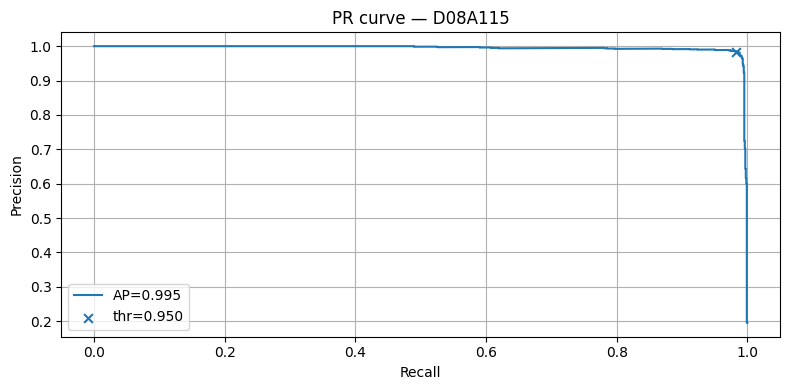


=== Per-station (manual thresholds) ===
D08A071: thr=0.500  Acc=0.996  Prec=0.984  Rec=0.994  TN=6248 FP=23 FN=8 TP=1386
D08A084: thr=0.500  Acc=0.991  Prec=0.917  Rec=0.987  TN=8653 FP=77 FN=11 TP=849
D08A115: thr=0.950  Acc=0.994  Prec=0.984  Rec=0.983  TN=5276 FP=20 FN=22 TP=1264

=== Combined CM (manual) ===
[[20177   120]
 [   41  3499]]
Saved stacking_v6_station_metrics_manual.csv


In [8]:

# %% Train & evaluate per station (manual thresholds, store probs for nudging)
results = []
all_cm  = np.zeros((2,2), dtype=int)
probs_store = {}
ytrue_store = {}
base_thr_store = {}

for code in STATIONS:
    print(f"\n=== Station {code} ===")
    base = load_station(code)
    X, y = build_features(base)

    # BEFORE training: show samples
    print(f"\n[{code}] raw hourly sample (rain_mm, discharge_cms)")
    display(base[['rain_mm','discharge_cms']].head(5))

    feat_preview = X.copy(); feat_preview['flood'] = y
    print(f"[{code}] engineered features + label (first 5 rows)")
    display(feat_preview.head(5))

    print(f"[{code}] rows={len(X):,}, features={X.shape[1]}")
    print("  overall flood rate :", _dist(y))
    if isinstance(X.index, pd.DatetimeIndex):
        print("  time span:", X.index.min(), "→", X.index.max())

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=SEED, stratify=y
    )

    # TRAIN/TEST samples
    print(f"[{code}] train/test split → X_train:{X_train.shape}, X_test:{X_test.shape}")
    print("  train flood rate:", _dist(y_train))
    print("  test  flood rate:", _dist(y_test))
    if isinstance(X.index, pd.DatetimeIndex):
        tr_blk = first_consecutive_index(X_train.index, 5)
        te_blk = first_consecutive_index(X_test.index, 5)
        print(f"[{code}] first 5 consecutive TRAIN rows:")
        display(pd.concat([X_train.loc[tr_blk], y_train.loc[tr_blk]], axis=1).rename(columns={'flood':'label'}))
        print(f"[{code}] first 5 consecutive TEST rows:")
        display(pd.concat([X_test.loc[te_blk], y_test.loc[te_blk]], axis=1).rename(columns={'flood':'label'}))

    # Pipeline: scale + stack
    num_cols = X.columns.tolist()
    pre  = ColumnTransformer([('sc', StandardScaler(), num_cols)], remainder='drop')
    base_models = make_base_models(int(y_train.sum()), int((y_train==0).sum()))
    stack = make_stacker(base_models)
    pipe = Pipeline([('pre', pre), ('model', stack)])
    pipe.fit(X_train, y_train)

    # Probabilities & AP
    y_prob = pipe.predict_proba(X_test)[:,1]
    ap = average_precision_score(y_test, y_prob)

    # Use manual threshold
    thr = MY_THR.get(code, 0.50)
    m   = evaluate_at_threshold(y_test.values, y_prob, thr)

    # SANITY: probability summary & first 5 test predictions
    pmin, p25, p50, p75, pmax = np.percentile(y_prob, [0,25,50,75,100])
    print(f"[{code}] proba summary → min:{pmin:.3f}  25%:{p25:.3f}  50%:{p50:.3f}  75%:{p75:.3f}  max:{pmax:.3f}")
    print(f"[{code}] chosen thr={thr:.3f} (manual)")
    te_show = pd.DataFrame(index=X_test.index, data={'y_true': y_test})
    te_show['prob'] = y_prob
    te_show['y_pred'] = (te_show['prob'] >= thr).astype(int)
    display(te_show.sort_index().head(5))

    results.append((code, thr, m))

    print(f"AP={ap:.3f}  Acc={m['acc']:.3f}  Prec={m['precision']:.3f}  Rec={m['recall']:.3f}")
    print(f"CM:\n[[{m['tn']:5d} {m['fp']:5d}]\n [{m['fn']:5d} {m['tp']:5d}]]")

    # PR curve
    P, R, T = precision_recall_curve(y_test, y_prob)
    plt.figure()
    plt.plot(R, P, label=f'AP={ap:.3f}')
    plt.scatter([m['recall']], [m['precision']], s=40, marker='x', label=f'thr={thr:.3f}')
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title(f'PR curve — {code}')
    plt.legend(); plt.tight_layout(); plt.show()

    # Accumulate combined CM
    y_hat = (y_prob >= thr).astype(int)
    all_cm += confusion_matrix(y_test, y_hat, labels=[0,1])

    # Store for nudging
    probs_store[code] = y_prob
    ytrue_store[code] = y_test.values
    base_thr_store[code] = float(thr)

print("\n=== Per-station (manual thresholds) ===")
for code, thr, m in results:
    print(f"{code}: thr={thr:.3f}  Acc={m['acc']:.3f}  Prec={m['precision']:.3f}  Rec={m['recall']:.3f}  "
          f"TN={m['tn']} FP={m['fp']} FN={m['fn']} TP={m['tp']}")

print("\n=== Combined CM (manual) ===")
print(all_cm)

# Export manual metrics
rows = []
for code, thr, m in results:
    row = {"station": code, "threshold": float(thr)}
    row.update({k: v for k, v in m.items() if k != "threshold"})
    rows.append(row)
pd.DataFrame(rows).sort_values('station').to_csv('stacking_v6_station_metrics_manual.csv', index=False)
print("Saved stacking_v6_station_metrics_manual.csv")


In [9]:

# %% Auto-nudge thresholds (±0.05), keep FN <= base FN, minimize FP
def nudge_threshold(y_true, y_prob, base_thr, window=0.05, step=0.001, max_fn_increase=0):
    # Base stats
    base_pred = (y_prob >= base_thr).astype(int)
    btn, bfp, bfn, btp = confusion_matrix(y_true, base_pred, labels=[0,1]).ravel()
    base = dict(threshold=float(base_thr), tn=int(btn), fp=int(bfp), fn=int(bfn), tp=int(btp))
    base['acc'] = (base['tp']+base['tn'])/(base['tp']+base['tn']+base['fp']+base['fn'])
    base['precision'] = precision_score(y_true, base_pred, zero_division=0)
    base['recall']    = recall_score(y_true, base_pred)
    base['ap']        = average_precision_score(y_true, y_prob)

    lo = max(0.0, base_thr - window); hi = min(1.0, base_thr + window)
    candidates = []
    thr = lo
    while thr <= hi + 1e-12:
        pred = (y_prob >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, pred, labels=[0,1]).ravel()
        if fn <= base['fn'] + int(max_fn_increase):
            prec = precision_score(y_true, pred, zero_division=0)
            rec  = recall_score(y_true, pred)
            candidates.append((fn, fp, -prec, abs(thr-base_thr),
                               dict(threshold=float(thr), tn=int(tn), fp=int(fp), fn=int(fn), tp=int(tp),
                                    acc=(tp+tn)/(tp+tn+fp+fn), precision=prec, recall=rec,
                                    ap=average_precision_score(y_true, y_prob))))
        thr += step

    if not candidates:
        return base
    candidates.sort(key=lambda t: (t[0], t[1], t[2], t[3]))
    return candidates[0][-1]

nudged = {}
overall_cm = np.zeros((2,2), dtype=int)
for code in STATIONS:
    yp = probs_store.get(code); yt = ytrue_store.get(code); thr0 = base_thr_store.get(code)
    if yp is None:
        print(f"[{code}] no stored probs; skip")
        continue
    best = nudge_threshold(yt, yp, thr0, window=0.05, step=0.001, max_fn_increase=0)
    nudged[code] = best
    btn, bfp, bfn, btp = confusion_matrix(yt, (yp>=thr0).astype(int), labels=[0,1]).ravel()
    print(f"{code}: base_thr={thr0:.3f} → nudged_thr={best['threshold']:.3f} | "
          f"FP {best['fp']} (base {bfp})  FN {best['fn']} (base {bfn})  "
          f"Prec {best['precision']:.3f}  Rec {best['recall']:.3f}")
    overall_cm += confusion_matrix(yt, (yp>=best['threshold']).astype(int), labels=[0,1])

print("\nCombined CM (nudged):")
print(overall_cm)
tn, fp, fn, tp = overall_cm.ravel()
overall_acc = (tp + tn) / (tp + tn + fp + fn)
overall_prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
overall_rec  = tp / (tp + fn) if (tp + fn) > 0 else 0.0
print(f"Overall: Acc={overall_acc:.3f}  Prec={overall_prec:.3f}  Rec={overall_rec:.3f}")

# Save nudged metrics
rows = []
for code, m in nudged.items():
    row = dict(station=code, **m)
    rows.append(row)
pd.DataFrame(rows).sort_values('station').to_csv('stacking_v6_station_metrics_nudged.csv', index=False)
print("Saved stacking_v6_station_metrics_nudged.csv")


D08A071: base_thr=0.500 → nudged_thr=0.459 | FP 23 (base 23)  FN 7 (base 8)  Prec 0.984  Rec 0.995
D08A084: base_thr=0.500 → nudged_thr=0.532 | FP 75 (base 77)  FN 11 (base 11)  Prec 0.919  Rec 0.987
D08A115: base_thr=0.950 → nudged_thr=0.927 | FP 22 (base 20)  FN 19 (base 22)  Prec 0.983  Rec 0.985

Combined CM (nudged):
[[20177   120]
 [   37  3503]]
Overall: Acc=0.993  Prec=0.967  Rec=0.990
Saved stacking_v6_station_metrics_nudged.csv


In [10]:

# %% Compare manual vs nudged
man = pd.read_csv('stacking_v6_station_metrics_manual.csv')
nud = pd.read_csv('stacking_v6_station_metrics_nudged.csv')

cmp = man.merge(nud, on='station', suffixes=('_man','_nud'))
cols = ['station','threshold_man','threshold_nud','fp_man','fp_nud','fn_man','fn_nud','precision_man','precision_nud','recall_man','recall_nud']
display(cmp[cols])

# Combined confusion matrices for both
cm_man = man[['tn','fp','fn','tp']].sum().values.reshape(2,2)
cm_nud = nud[['tn','fp','fn','tp']].sum().values.reshape(2,2)
print("Combined CM (manual):\n", cm_man)
print("Combined CM (nudged):\n", cm_nud)


,station,threshold_man,threshold_nud,fp_man,fp_nud,fn_man,fn_nud,precision_man,precision_nud,recall_man,recall_nud
0,D08A071,0.50,0.459,23,23,8,7,0.983676,0.983688,0.994261,0.994978
1,D08A084,0.50,0.532,77,75,11,11,0.916847,0.918831,0.987209,0.987209
2,D08A115,0.95,0.927,20,22,22,19,0.984424,0.982933,0.982893,0.985226


Combined CM (manual):
 [[20177   120]
 [   41  3499]]
Combined CM (nudged):
 [[20177   120]
 [   37  3503]]


In [12]:
from sklearn.calibration import CalibratedClassifierCV

def apply_persistence_and_cooldown(binary_preds, persistence=3, cooldown=6):
    out = np.zeros_like(binary_preds, dtype=int)
    consec = 0; active = False; cooldown_left = 0
    for i, b in enumerate(binary_preds):
        if cooldown_left > 0:
            out[i] = 0
            cooldown_left -= 1
            consec = (consec + 1) if b==1 else 0
            consec = min(consec, persistence)
            continue
        if not active:
            if b == 1:
                consec += 1
                if consec >= persistence:
                    active = True
                    out[i] = 1
                else:
                    out[i] = 0
            else:
                consec = 0
                out[i] = 0
        else:
            if b == 1:
                out[i] = 1
                consec = persistence
            else:
                out[i] = 0
                active = False
                consec = 0
                cooldown_left = cooldown
    return out

def evaluate_with_persistence(y_true, y_prob, thr, persistence=3, cooldown=6):
    raw = (y_prob >= thr).astype(int)
    filt = apply_persistence_and_cooldown(raw, persistence, cooldown)
    tn, fp, fn, tp = confusion_matrix(y_true, filt, labels=[0,1]).ravel()
    acc = (tp+tn)/(tp+tn+fp+fn)
    prec = tp/(tp+fp) if (tp+fp)>0 else 0.0
    rec  = tp/(tp+fn) if (tp+fn)>0 else 0.0
    ap   = average_precision_score(y_true, y_prob)
    return dict(threshold=float(thr), acc=acc, precision=prec, recall=rec, ap=ap,
                tn=int(tn), fp=int(fp), fn=int(fn), tp=int(tp))

def nudge_threshold_with_persistence(y_true, y_prob, base_thr,
                                     window=0.05, step=0.001,
                                     persistence=3, cooldown=6, max_fn_increase=0):
    base = evaluate_with_persistence(y_true, y_prob, base_thr, persistence, cooldown)
    lo = max(0.0, base_thr - window); hi = min(1.0, base_thr + window)
    best = base; best_key = (base['fn'], base['fp'], -base['precision'], 0.0)
    thr = lo
    while thr <= hi + 1e-12:
        m = evaluate_with_persistence(y_true, y_prob, thr, persistence, cooldown)
        if m['fn'] <= base['fn'] + int(max_fn_increase):
            key = (m['fn'], m['fp'], -m['precision'], abs(thr-base_thr))
            if key < best_key:
                best, best_key = m, key
        thr += step
    return best

In [13]:
results_manual = []
results_nudged = []
all_cm_manual  = np.zeros((2,2), dtype=int)
all_cm_nudged  = np.zeros((2,2), dtype=int)

for code in STATIONS:
    print(f"\n=== Station {code} ===")
    base = load_station(code)
    X, y = build_features(base)

    # 70/30 split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=SEED, stratify=y)
    # calibration split (80/20 of training)
    X_fit, X_cal, y_fit, y_cal = train_test_split(X_train, y_train, test_size=0.20, random_state=SEED, stratify=y_train)

    # stack pipeline
    num_cols = X.columns.tolist()
    pre = ColumnTransformer([('sc', StandardScaler(), num_cols)], remainder='drop')
    base_models = make_base_models(int(y_fit.sum()), int((y_fit==0).sum()))
    stack = make_stacker(base_models)
    pipe = Pipeline([('pre', pre), ('model', stack)])

    # fit on fit-split
    pipe.fit(X_fit, y_fit)

    # calibrate on cal-split (isotonic)
    calibrator = CalibratedClassifierCV(pipe, method='isotonic', cv='prefit')
    calibrator.fit(X_cal, y_cal)

    # test probabilities
    y_prob = calibrator.predict_proba(X_test)[:,1]

    # MANUAL thr (with persistence)
    thr0 = MY_THR.get(code, 0.5)
    m_man = evaluate_with_persistence(y_test.values, y_prob, thr0,
                                      persistence=PERSISTENCE_HRS, cooldown=COOLDOWN_HRS)
    results_manual.append((code, thr0, m_man))
    print(f"[manual] thr={thr0:.3f} | Acc={m_man['acc']:.3f} Prec={m_man['precision']:.3f} Rec={m_man['recall']:.3f}  "
          f"TN={m_man['tn']} FP={m_man['fp']} FN={m_man['fn']} TP={m_man['tp']}")

    # NUDGE around manual, keep FN ≤ base (with persistence)
    best = nudge_threshold_with_persistence(y_test.values, y_prob, thr0,
                                            window=0.05, step=0.001,
                                            persistence=PERSISTENCE_HRS, cooldown=COOLDOWN_HRS,
                                            max_fn_increase=0)
    results_nudged.append((code, best['threshold'], best))
    print(f"[nudged] thr={best['threshold']:.3f} | Acc={best['acc']:.3f} Prec={best['precision']:.3f} Rec={best['recall']:.3f}  "
          f"TN={best['tn']} FP={best['fp']} FN={best['fn']} TP={best['tp']}")

    # accumulate combined CMs (manual & nudged)
    yhat_man = apply_persistence_and_cooldown((y_prob >= thr0).astype(int),
                                              persistence=PERSISTENCE_HRS, cooldown=COOLDOWN_HRS)
    yhat_nud = apply_persistence_and_cooldown((y_prob >= best['threshold']).astype(int),
                                              persistence=PERSISTENCE_HRS, cooldown=COOLDOWN_HRS)
    all_cm_manual += confusion_matrix(y_test, yhat_man, labels=[0,1])
    all_cm_nudged += confusion_matrix(y_test, yhat_nud, labels=[0,1])

print("\n=== Manual (with persistence) ===")
for code, thr, m in results_manual:
    print(f"{code}: thr={thr:.3f}  Acc={m['acc']:.3f} Prec={m['precision']:.3f} Rec={m['recall']:.3f}  "
          f"TN={m['tn']} FP={m['fp']} FN={m['fn']} TP={m['tp']}")
print("Combined CM (manual):\n", all_cm_manual)

print("\n=== Nudged (with persistence) ===")
for code, thr, m in results_nudged:
    print(f"{code}: thr={thr:.3f}  Acc={m['acc']:.3f} Prec={m['precision']:.3f} Rec={m['recall']:.3f}  "
          f"TN={m['tn']} FP={m['fp']} FN={m['fn']} TP={m['tp']}")
print("Combined CM (nudged):\n", all_cm_nudged)

# Export
rows=[]
for code, thr, m in results_manual:
    row={'station':code,'mode':'manual','threshold':float(thr),
         'persistence':PERSISTENCE_HRS,'cooldown':COOLDOWN_HRS}
    row.update({k:v for k,v in m.items() if k!='threshold'})
    rows.append(row)
for code, thr, m in results_nudged:
    row={'station':code,'mode':'nudged','threshold':float(thr),
         'persistence':PERSISTENCE_HRS,'cooldown':COOLDOWN_HRS}
    row.update({k:v for k,v in m.items() if k!='threshold'})
    rows.append(row)
pd.DataFrame(rows).to_csv('stacking_v7_metrics.csv', index=False)
print("Saved stacking_v7_metrics.csv")


=== Station D08A071 ===
[manual] thr=0.500 | Acc=0.824 Prec=0.978 Rec=0.032  TN=6270 FP=1 FN=1349 TP=45
[nudged] thr=0.500 | Acc=0.824 Prec=0.978 Rec=0.032  TN=6270 FP=1 FN=1349 TP=45

=== Station D08A084 ===
[manual] thr=0.500 | Acc=0.911 Prec=1.000 Rec=0.007  TN=8730 FP=0 FN=854 TP=6
[nudged] thr=0.500 | Acc=0.911 Prec=1.000 Rec=0.007  TN=8730 FP=0 FN=854 TP=6

=== Station D08A115 ===
[manual] thr=0.950 | Acc=0.811 Prec=0.978 Rec=0.035  TN=5295 FP=1 FN=1241 TP=45
[nudged] thr=0.950 | Acc=0.811 Prec=0.978 Rec=0.035  TN=5295 FP=1 FN=1241 TP=45

=== Manual (with persistence) ===
D08A071: thr=0.500  Acc=0.824 Prec=0.978 Rec=0.032  TN=6270 FP=1 FN=1349 TP=45
D08A084: thr=0.500  Acc=0.911 Prec=1.000 Rec=0.007  TN=8730 FP=0 FN=854 TP=6
D08A115: thr=0.950  Acc=0.811 Prec=0.978 Rec=0.035  TN=5295 FP=1 FN=1241 TP=45
Combined CM (manual):
 [[20295     2]
 [ 3444    96]]

=== Nudged (with persistence) ===
D08A071: thr=0.500  Acc=0.824 Prec=0.978 Rec=0.032  TN=6270 FP=1 FN=1349 TP=45
D08A084: th